<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson12_Interpretation/Models_Interpretation_screencast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы интерпретации моделей

In [1]:
!pip install lime -q
!pip install shap -q
!pip install eli5 -q
!pip install catboost -q

In [2]:
!pip install scikit-learn==1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import eli5
import shap
import lime

from catboost import CatBoostRegressor

RANDOM_STATE = 42

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Будем решать задачу регрессии - прогнозировать стоимость домов в Калифорнии

In [4]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

X_train.shape, X_test.shape

((15480, 8), (5160, 8))

In [6]:
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

### Подход 1: классический feature importance

Нарисуем гистограмму важности признаков, посчитанную стандартным способом (через Information Gain)

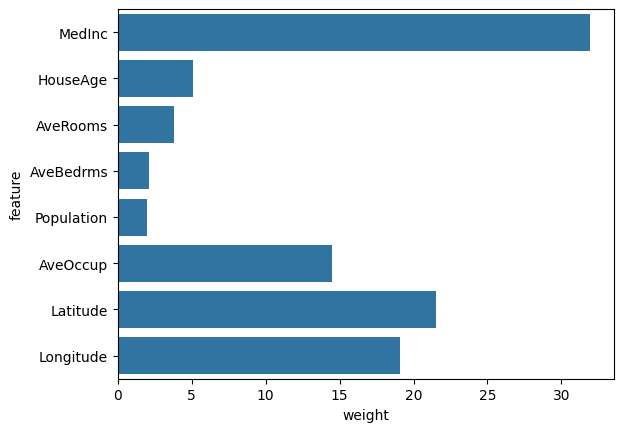

In [7]:
model_imps = pd.DataFrame({"feature": X.columns,
                        "weight": model.feature_importances_})
sns.barplot(data=model_imps, y="feature", x="weight")
plt.show()

### Подход 2: permutation importance

In [8]:
perm = eli5.sklearn.PermutationImportance(model, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

### Подход 3: значения Шепли (shap values)


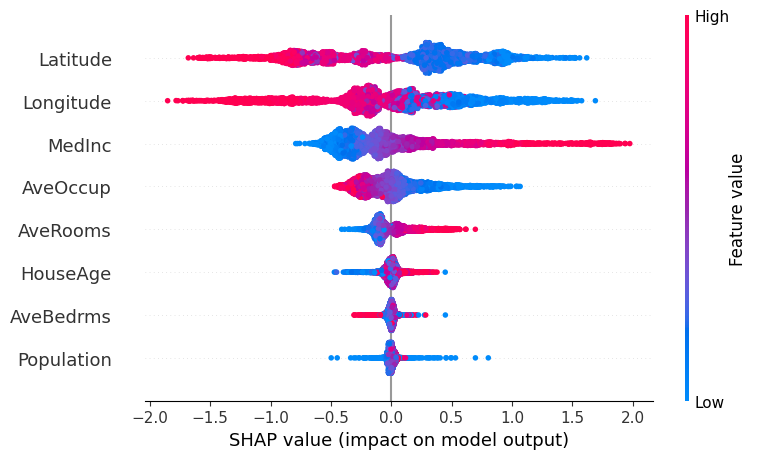

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Проинтерпретируем какой-нибудь индивидуальный прогноз модели

In [10]:
shap.initjs()

print('Correct answer:', y_test.iloc[2])
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

Correct answer: 5.00001


### Подход 4: LIME

Проинтерпретируем индивидуальный прогноз модели при помощи LIME

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns.values.tolist(), mode='regression')
explanation = explainer.explain_instance(X_test.values[2], model.predict, num_features=5)

explanation.show_in_notebook(show_table=True)